In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from functools import partial
from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display
from scipy.linalg import block_diag

In [3]:
#pydrake imports
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint
from pydrake.all import RotationMatrix, Rgba
import time
import pydrake.multibody.rational as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import IrisOptions, IrisInRationalConfigurationSpace, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions

In [4]:
from pydrake.geometry.optimization_dev import (CspaceFreePolytope, 
                                               SeparatingPlaneOrder)

# Build and set up the visualization the plant and the visualization of the C-space obstacle

We first set up a simple 2-DOF system and visualize both the plant and the configuration constraint.Click on the two links at the bottom to view the plant and the configuration space.

Note that running this cell multiple times will establish multiple meshcat instances which can fill up your memory. It is a good idea to call "pkill -f meshcat" from the command line before re-running this cell


In [5]:
#construct our robot
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)
oneDOF_iiwa_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/oneDOF_iiwa7_with_box_collision.sdf")

box_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/box_small.urdf")

models = []
models.append(parser.AddModelFromFile(box_asset))
models.append(parser.AddModelFromFile(oneDOF_iiwa_asset, 'right_sweeper'))
models.append(parser.AddModelFromFile(oneDOF_iiwa_asset, 'left_sweeper'))
locs = [[0.,0.,0.],
        [0,1,0.85],
        [0,-1,0.55]]
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("base", models[0]),
                 RigidTransform(locs[0]))

t1 = RigidTransform(RollPitchYaw([np.pi/2, 0, 0]).ToRotationMatrix(), locs[1])@RigidTransform(RollPitchYaw([0, 0, np.pi/2]), np.zeros(3))
t2 = RigidTransform(RollPitchYaw([-np.pi/2, 0, 0]).ToRotationMatrix(), locs[2])@RigidTransform(RollPitchYaw([0, 0, np.pi/2]), np.zeros(3))
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_oneDOF_link_0", models[1]), 
                 t1)
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_oneDOF_link_0", models[2]), 
                 t2)


plant.Finalize()
idx = 0
q0 = [0.0, 0.0]
val = 1.7
q_low  = np.array([-val, -val])
q_high = np.array([val, val])
# set the joint limits of the plant
for model in models:
    for joint_index in plant.GetJointIndices(model):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[idx])
            joint.set_position_limits(lower_limits= np.array([q_low[idx]]), upper_limits= np.array([q_high[idx]]))
            idx += 1
        
# construct the RationalForwardKinematics of this plant. This object handles the
# computations for the forward kinematics in the tangent-configuration space
Ratfk = RationalForwardKinematics(plant)

# the point about which we will take the stereographic projections
q_star = np.zeros(plant.num_positions())

do_viz = True

# The object we will use to perform our certification.
cspace_free_polytope = CspaceFreePolytope(plant, scene_graph, SeparatingPlaneOrder.kAffine, q_star)

# This line builds the visualization. Change the viz_role to Role.kIllustration if you
# want to see the plant with its illustrated geometry or to Role.kProximity if you want
# to see the plant with the collision geometries.
visualizer = IrisPlantVisualizer(plant, builder, scene_graph, cspace_free_polytope, viz_role=Role.kIllustration)
visualizer.visualize_collision_constraint(factor = 1.2, num_points = 500)
visualizer.meshcat_cspace.Set2dRenderMode(RigidTransform(RotationMatrix.MakeZRotation(0), np.array([0,0,1])))
visualizer.meshcat_task_space.Set2dRenderMode(RigidTransform(RotationMatrix.MakeZRotation(0), np.array([1,0,0])))

INFO:drake:Meshcat listening for connections at http://localhost:7002
INFO:drake:Meshcat listening for connections at http://localhost:7003


## Set up the sliders so we can move the plant around manually

You can use the sliders below to move the two degrees of freedom of the plant around. A green dot will appear in the TC-space visualization describing the current TC-space configuration.

In [6]:
sliders = []
sliders.append(widgets.FloatSlider(min=q_low[0], max=q_high[0], value=0, description='q0', step = 0.02))
sliders.append(widgets.FloatSlider(min=q_low[1], max=q_high[1], value=0, description='q1', step = 0.02))

q = q0.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    visualizer.show_res_q(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)


FloatSlider(value=0.0, description='q0', max=1.7, min=-1.7, step=0.02)

FloatSlider(value=0.0, description='q1', max=1.7, min=-1.7, step=0.02)

# Generate and Certify Regions

Around some nominal seed postures, we will grow certified regions by seeding our alternation algorithm using a small initial polytope.

In [7]:
# Some seedpoints
seed_points_q = np.array([   
                              [0.0, 0],
                              [0.7, -0.9],
                              [-0.5, -0.5],
                              [0.5,-1.08],
                              [-1.06, 0.48]
                              ])

seed_points = np.array([Ratfk.ComputeSValue(seed_points_q[idx], np.zeros((2,)))\
                        for idx in range(seed_points_q.shape[0])])
start = seed_points[0]
end = seed_points[-1]

visualizer.plot_cspace_points(seed_points, "/iris_seed_points", radius = 0.02)
    


default_scale = 1e-2
L1_ball = HPolyhedron.MakeL1Ball(2)
Linf_ball = HPolyhedron.MakeBox(-np.ones(2), np.ones(2))

template_C = np.vstack([L1_ball.A(), Linf_ball.A()])
template_d = np.hstack([default_scale*L1_ball.b(), default_scale/np.sqrt(2)*Linf_ball.b()])


def make_default_polytope_at_point(seed_point):
    return HPolyhedron(template_C, template_d + template_C @ seed_point)


# colors to plot the region. Chosen for color-blind compatibility
default_alpha = 0.2
colors_dict = {
    0: Rgba(0.565, 0.565, 0.565, default_alpha), # gray
    1: Rgba(0.118, 0.533, 0.898, default_alpha), # bluish
    2: Rgba(1,     0.757, 0.027, default_alpha), # gold
    3: Rgba(0,     0.549, 0.024, default_alpha), # green   
    4: Rgba(0.055, 0.914, 0.929, default_alpha), # teal 
}

initial_regions = [(make_default_polytope_at_point(s), colors_dict[i]) for i, s in enumerate(seed_points)]
visualizer.add_group_of_regions_to_visualization(initial_regions, "initial_regions",
                            wireframe = False,
                           opacity = default_alpha)
visualizer.show_res_q(q_star)

visualizer.add_plane_indices_of_interest(118)

## First we set up some options for our different certification modes

In [8]:
# set up the certifier and the options for different search techniques
solver_options = SolverOptions()
# set this to 1 if you would like to see the solver output in terminal.
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 0)

# The options for when we search for new planes and positivity certificates given the polytopes
find_separation_certificate_given_polytope_options = CspaceFreePolytope.FindSeparationCertificateGivenPolytopeOptions()
find_separation_certificate_given_polytope_options.num_threads = -1
find_separation_certificate_given_polytope_options.verbose = False
find_separation_certificate_given_polytope_options.solver_options = solver_options
find_separation_certificate_given_polytope_options.ignore_redundant_C = False

# The options for when we search for a new polytope given positivity certificates.
find_polytope_given_lagrangian_option = CspaceFreePolytope.FindPolytopeGivenLagrangianOptions()
find_polytope_given_lagrangian_option.solver_options = solver_options
find_polytope_given_lagrangian_option.ellipsoid_margin_cost = CspaceFreePolytope.EllipsoidMarginCost.kGeometricMean
find_polytope_given_lagrangian_option.search_s_bounds_lagrangians = True
find_polytope_given_lagrangian_option.ellipsoid_margin_epsilon = 1e-8


bilinear_alternation_options = CspaceFreePolytope.BilinearAlternationOptions()
bilinear_alternation_options.max_iter = 100
bilinear_alternation_options.convergence_tol = 1e-5
bilinear_alternation_options.find_polytope_options = find_polytope_given_lagrangian_option
bilinear_alternation_options.find_lagrangian_options = find_separation_certificate_given_polytope_options

binary_search_options = CspaceFreePolytope.BinarySearchOptions()
binary_search_options.find_lagrangian_options = find_separation_certificate_given_polytope_options
binary_search_options.scale_min = 1
binary_search_options.scale_max = 50
binary_search_options.max_iter = 100

Clim = np.vstack([np.eye(q_star.shape[0]), -np.eye(q_star.shape[0])])
dlim = np.concatenate([Ratfk.ComputeSValue(q_high, q_star), -Ratfk.ComputeSValue(q_low, q_star)])
def polytope_with_joint_limits(C, d):
    return HPolyhedron(np.vstack([C, Clim]), np.concatenate([d, dlim]))

In [9]:
region = initial_regions[0][0]
progs = cspace_free_polytope.ConstructPlaneSearchProgramsForPairs(region.A(), region.b(), find_separation_certificate_given_polytope_options)

In [10]:
len(cspace_free_polytope.separating_planes())

130

In [11]:
cert_prog = progs[0].prog()
print(cert_prog.num_vars())
print(len(cert_prog.GetAllConstraints()))

300
224


# Growing regions with bilinear alternations search

### As the initial regions are fairly small, they won't contain collisions and so can be directly fed into the bilinear alternation algorithm.

In [12]:
# We grow certified regions around each seedpoint using bilinear alternation.
from time import perf_counter
bilinear_alternation_results_by_seed_point = dict.fromkeys([tuple(s) for s in seed_points])
times_per_region = []
for i, (s, (initial_region, color)) in enumerate(zip(seed_points, initial_regions)):
    print(f"starting seedpoint {i+1}/{len(initial_regions)}")
    time.sleep(0.1) # make the above print before the Drake log.
    bilinear_alternation_options.find_polytope_options.s_inner_pts = s
    t_start = time.perf_counter()
    result = cspace_free_polytope.SearchWithBilinearAlternation(set(), initial_region.A(),
                                                                initial_region.b(),
                                                                bilinear_alternation_options)
    t_end = time.perf_counter()
    times_per_region.append(t_end - t_start)
    bilinear_alternation_results_by_seed_point[tuple(s)] = [(polytope_with_joint_limits(cert.C, cert.d),
                                                             cert, color) for cert in result]
    



INFO:drake:det(Q) at the beginning is 4.900500382473016e-05
INFO:drake:Total Lagrangian step time 1.408 s


starting seedpoint 1/5


INFO:drake:Iteration 0: det(Q)=0.00014576238925864208
INFO:drake:Total Lagrangian step time 1.61 s
INFO:drake:Iteration 1: det(Q)=0.0002806159113297737
INFO:drake:Total Lagrangian step time 1.238 s
INFO:drake:Iteration 2: det(Q)=0.0005344000732312085
INFO:drake:Total Lagrangian step time 1.436 s
INFO:drake:Iteration 3: det(Q)=0.0009169467132802288
INFO:drake:Total Lagrangian step time 1.314 s
INFO:drake:Iteration 4: det(Q)=0.0013848549945793937
INFO:drake:Total Lagrangian step time 1.304 s
INFO:drake:Iteration 5: det(Q)=0.0019126336178197192
INFO:drake:Total Lagrangian step time 1.637 s
INFO:drake:Iteration 6: det(Q)=0.00255550225428644
INFO:drake:Total Lagrangian step time 1.325 s
INFO:drake:Iteration 7: det(Q)=0.003337093699566204
INFO:drake:Total Lagrangian step time 1.405 s
INFO:drake:Iteration 8: det(Q)=0.00430669080783459
INFO:drake:Total Lagrangian step time 1.609 s
INFO:drake:Iteration 9: det(Q)=0.005568220382883087
INFO:drake:Total Lagrangian step time 1.341 s
INFO:drake:Itera

INFO:drake:Total Lagrangian step time 1.54 s
INFO:drake:Iteration 84: det(Q)=0.05429087045116916
INFO:drake:Total Lagrangian step time 1.514 s
INFO:drake:Iteration 85: det(Q)=0.054338708430600534
INFO:drake:Total Lagrangian step time 1.453 s
INFO:drake:Iteration 86: det(Q)=0.054385891679635576
INFO:drake:Total Lagrangian step time 1.391 s
INFO:drake:Iteration 87: det(Q)=0.054432499848688046
INFO:drake:Total Lagrangian step time 1.546 s
INFO:drake:Iteration 88: det(Q)=0.05447859958426209
INFO:drake:Total Lagrangian step time 1.549 s
INFO:drake:Iteration 89: det(Q)=0.054522689752984306
INFO:drake:Total Lagrangian step time 1.497 s
INFO:drake:Iteration 90: det(Q)=0.05456462035122445
INFO:drake:Total Lagrangian step time 1.48 s
INFO:drake:Iteration 91: det(Q)=0.05460406651203909
INFO:drake:Total Lagrangian step time 1.433 s
INFO:drake:Iteration 92: det(Q)=0.05464058306726241
INFO:drake:Total Lagrangian step time 1.437 s
INFO:drake:Iteration 93: det(Q)=0.054674656520404985
INFO:drake:Total 

starting seedpoint 2/5


INFO:drake:Iteration 0: det(Q)=0.00014131240847090125
INFO:drake:Total Lagrangian step time 1.437 s
INFO:drake:Iteration 1: det(Q)=0.00036805961026473594
INFO:drake:Total Lagrangian step time 1.373 s
INFO:drake:Iteration 2: det(Q)=0.0007327701038891825
INFO:drake:Total Lagrangian step time 1.462 s
INFO:drake:Iteration 3: det(Q)=0.001456733282687195
INFO:drake:Total Lagrangian step time 1.54 s
INFO:drake:Iteration 4: det(Q)=0.002961332348494822
INFO:drake:Total Lagrangian step time 1.509 s
INFO:drake:Iteration 5: det(Q)=0.005965834368885852
INFO:drake:Total Lagrangian step time 1.544 s
INFO:drake:Iteration 6: det(Q)=0.009942655734023328
INFO:drake:Total Lagrangian step time 1.445 s
INFO:drake:Iteration 7: det(Q)=0.01235925129642312
INFO:drake:Total Lagrangian step time 1.383 s
INFO:drake:Iteration 8: det(Q)=0.013822141909334801
INFO:drake:Total Lagrangian step time 1.439 s
INFO:drake:Iteration 9: det(Q)=0.015100253158656518
INFO:drake:Total Lagrangian step time 1.422 s
INFO:drake:Iterat

starting seedpoint 3/5


INFO:drake:Total Lagrangian step time 0.905 s
INFO:drake:Iteration 0: det(Q)=0.0002893803632078695
INFO:drake:Total Lagrangian step time 0.88 s
INFO:drake:Iteration 1: det(Q)=0.000629240698708994
INFO:drake:Total Lagrangian step time 0.947 s
INFO:drake:Iteration 2: det(Q)=0.0010005786406084907
INFO:drake:Total Lagrangian step time 1.161 s
INFO:drake:Iteration 3: det(Q)=0.0015026235141849568
INFO:drake:Total Lagrangian step time 0.9 s
INFO:drake:Iteration 4: det(Q)=0.0022000574340110984
INFO:drake:Total Lagrangian step time 0.966 s
INFO:drake:Iteration 5: det(Q)=0.0030720890177413714
INFO:drake:Total Lagrangian step time 1.017 s
INFO:drake:Iteration 6: det(Q)=0.004162115304839216
INFO:drake:Total Lagrangian step time 1.08 s
INFO:drake:Iteration 7: det(Q)=0.005547234537234709
INFO:drake:Total Lagrangian step time 0.984 s
INFO:drake:Iteration 8: det(Q)=0.0074292604396001775
INFO:drake:Total Lagrangian step time 1.109 s
INFO:drake:Iteration 9: det(Q)=0.010085315083395479
INFO:drake:Total L

starting seedpoint 4/5


INFO:drake:Total Lagrangian step time 0.988 s
INFO:drake:Iteration 0: det(Q)=0.00010339887932332229
INFO:drake:Total Lagrangian step time 1.14 s
INFO:drake:Iteration 1: det(Q)=0.00018579145628959672
INFO:drake:Total Lagrangian step time 0.981 s
INFO:drake:Iteration 2: det(Q)=0.0002769318578043369
INFO:drake:Total Lagrangian step time 0.871 s
INFO:drake:Iteration 3: det(Q)=0.0004675590586949072
INFO:drake:Total Lagrangian step time 1.018 s
INFO:drake:Iteration 4: det(Q)=0.0007918939209971374
INFO:drake:Total Lagrangian step time 0.991 s
INFO:drake:Iteration 5: det(Q)=0.0011657905502829118
INFO:drake:Total Lagrangian step time 0.88 s
INFO:drake:Iteration 6: det(Q)=0.0017386046717462675
INFO:drake:Total Lagrangian step time 0.921 s
INFO:drake:Iteration 7: det(Q)=0.002541565057009815
INFO:drake:Total Lagrangian step time 0.901 s
INFO:drake:Iteration 8: det(Q)=0.0034983439448962165
INFO:drake:Total Lagrangian step time 1.015 s
INFO:drake:Iteration 9: det(Q)=0.0046491207103816845
INFO:drake:

starting seedpoint 5/5


INFO:drake:Total Lagrangian step time 0.97 s
INFO:drake:Iteration 0: det(Q)=9.187667490570257e-05
INFO:drake:Total Lagrangian step time 1.096 s
INFO:drake:Iteration 1: det(Q)=0.00015239078399186516
INFO:drake:Total Lagrangian step time 1.268 s
INFO:drake:Iteration 2: det(Q)=0.00023425033830250453
INFO:drake:Total Lagrangian step time 1.154 s
INFO:drake:Iteration 3: det(Q)=0.0003362913456625858
INFO:drake:Total Lagrangian step time 0.983 s
INFO:drake:Iteration 4: det(Q)=0.00047180029306225185
INFO:drake:Total Lagrangian step time 0.856 s
INFO:drake:Iteration 5: det(Q)=0.000631131513203011
INFO:drake:Total Lagrangian step time 0.953 s
INFO:drake:Iteration 6: det(Q)=0.0008448350871849316
INFO:drake:Total Lagrangian step time 1.016 s
INFO:drake:Iteration 7: det(Q)=0.0011059142547443187
INFO:drake:Total Lagrangian step time 0.928 s
INFO:drake:Iteration 8: det(Q)=0.0014591068950592092
INFO:drake:Total Lagrangian step time 0.933 s
INFO:drake:Iteration 9: det(Q)=0.001984403557036214
INFO:drake

In [13]:
for i in range(seed_points.shape[0]):
    print(f"Time to generate region {i} ={times_per_region[i]}")
print(f"Total time = {sum(times_per_region)}")

Time to generate region 0 =451.16537690901896
Time to generate region 1 =286.2568278569961
Time to generate region 2 =183.65680388896726
Time to generate region 3 =298.10215059202164
Time to generate region 4 =220.33412404498085
Total time = 1439.5152832919848


In [14]:
bil_alt_final_result = [result[-1] for result in bilinear_alternation_results_by_seed_point.values()]
group_name = f"/bil_alt_final_result"
visualizer.add_group_of_regions_and_certs_to_visualization(bil_alt_final_result, group_name, 
                                                               wireframe = False, opacity = 0.2)

In [22]:
#visualize some imporatnt posture
q_to_visit = np.array([
    [-1.06, 0.44],
    [-0.98, -0.92],
    [0.62, -1.32],
    [0.62, -0.44],
    [0, 0]
])
plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}
geoms = plane_indices_to_geometries[118]

In [33]:
#visualize some imporatnt posture
i = 2
visualizer.show_res_q(q_to_visit[i])
plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}
geoms = plane_indices_to_geometries[118]
visualizer.highlight_geometry_id(geoms[0], Rgba(0,0,0,1))
visualizer.highlight_geometry_id(geoms[1], Rgba(0,0,0,1))

In [15]:
# visualize the regions and corresponding certificates
# for i, result in enumerate(bilinear_alternation_results_by_seed_point.values()):
#     group_name = f"/bil_alt_seed_point_{i}"
#     visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
                                                               wireframe = False, opacity = 0.2)

SyntaxError: invalid syntax (<ipython-input-15-69f6c5e21e47>, line 1)

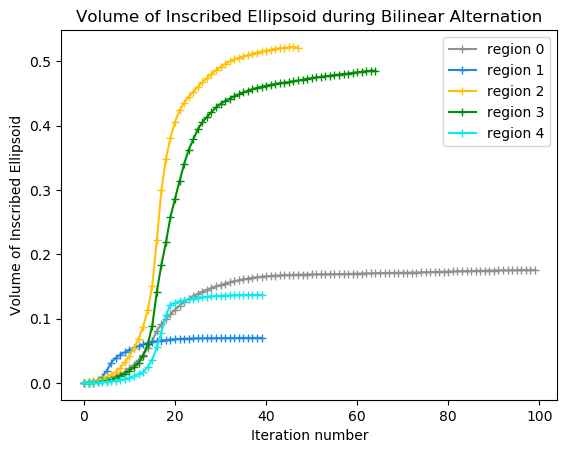

In [32]:
import matplotlib.pyplot as plt
plt.clf()
bilinear_alternation_results_by_seed_point_values = list(bilinear_alternation_results_by_seed_point.values())
for i in [0,1,2,3,4]:#[3,2,0,1,4]:
    result = bilinear_alternation_results_by_seed_point_values[i]
    color = (colors_dict[i].r(), colors_dict[i].g(), colors_dict[i].b())
    data = [(c.num_iter, c.certified_polytope.MaximumVolumeInscribedEllipsoid().Volume()) 
        for (_, c, _) in result]
    x, y = map(list, zip(*data))
    plt.plot(x, y, color = color, marker = '+', label = f"region {i}")
plt.xlabel("Iteration number")
plt.ylabel("Volume of Inscribed Ellipsoid")
plt.title("Volume of Inscribed Ellipsoid during Bilinear Alternation")
plt.legend()
plt.savefig("pinball_vol.svg")
plt.show()

In [ ]:
for slider in sliders:
    display(slider)

## Seeding and Certifying with a Stronger Heuristic
We have also implemented another, strong heuristic for proposing good initial regions based on non-linear optimization. See Appendix TODO of our paper TODO for details

In [ ]:
# iris_regions = []
# iris_ellipses = []

# iris_options = IrisOptions()
# iris_options.require_sample_point_is_contained = True
# iris_options.configuration_space_margin = 1e-3
# iris_options.relative_termination_threshold = 0.001

# context_for_iris = visualizer.task_space_diagram_context
# for i, s in enumerate(seed_points):
#     q = Ratfk.ComputeQValue(s, q_star)
#     plant.SetPositions(plant.GetMyMutableContextFromRoot(context_for_iris), q)
#     r = IrisInRationalConfigurationSpace(plant, 
#                                          plant.GetMyContextFromRoot(context_for_iris),
#                                          q_star, iris_options)
#     iris_regions.append((r, colors_dict[i]))
#     iris_ellipses.append(r.MaximumVolumeInscribedEllipsoid())
    

# visualizer.add_group_of_regions_to_visualization(iris_regions, "/uncertified_iris", 
#                                                             wireframe = False, opacity = 0.2)

In [ ]:
# binary_search_options_for_iris = CspaceFreePolytope.BinarySearchOptions()
# binary_search_options_for_iris.scale_max = 1.0 # it is highly unlikely that the regions can grow, but we can try
# binary_search_options_for_iris.find_lagrangian_options = find_separation_certificate_given_polytope_options
# binary_search_options_for_iris.max_iter = 50
# binary_search_region_certificates_for_iris = dict.fromkeys([tuple(s) for s in seed_points])
# for i, (s, (initial_region, color)) in enumerate(zip(seed_points, iris_regions)):
#     print(f"starting seedpoint {i+1}/{len(iris_regions)}")
#     time.sleep(0.2)    
#     cert = cspace_free_polytope.BinarySearch(set(),
#                                                     initial_region.A(),
#                                                     initial_region.b(), 
#                                                     initial_region.MaximumVolumeInscribedEllipsoid().center(), 
#                                                     binary_search_options_for_iris)
#     binary_search_region_certificates_for_iris[tuple(s)] = [(polytope_with_joint_limits(cert.C, cert.d),
#                                                              cert, color)]
# for i, result in enumerate(binary_search_region_certificates_for_iris.values()):
#     group_name = f"/certified-iris-bin_seed_point_{i}"
#     visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
#                                                             wireframe = False, opacity = 0.2)

In [ ]:
# from gcs.bezier import BezierGCS
# from gcs.linear import LinearGCS
# from pydrake.solvers.mosek import MosekSolver
# from pydrake.all import PiecewisePolynomial
# from visualization_utils import draw_traj

# start = seed_points[0]
# end = seed_points[-1]
# regions = [r for (r,_) in iris_regions]

# l_gcs = LinearGCS(regions)
# l_gcs.addSourceTarget(start, end)
# l_gcs.setSolver(MosekSolver())
# waypoints = l_gcs.SolvePath(True)[0]
# t_knots = np.linspace(0, 1,  waypoints.shape[1])
# lin_traj = PiecewisePolynomial.FirstOrderHold(t_knots, waypoints)

# draw_traj(visualizer.meshcat_cspace, lin_traj, 100)


In [ ]:
# substeps = 100
# runtime = 2*substeps
# # visualizer.animate_traj_s(lin_traj, substeps, runtime)
# visualizer.visualizer_task_space.StartRecording()
# visualizer.animate_traj_s(lin_traj, substeps, runtime)
# visualizer.visualizer_task_space.PublishRecording()


In [ ]:
# visualizer.save_meshcats("pinball_iiwas")

# Now it is time to play with the visualization! If you open the task space visualizer, we can highlight specific geometries and their separating planes in different regions.
## Notice that when regions overlap, we get multiple planes certifying non-collision

In [ ]:
# This plane certifies that the two tips of the flippers don't intersect
visualizer.add_plane_indices_of_interest(118)

# re-display the sliders for convenience
for slider in sliders:
    display(slider)

In [ ]:
# Uncomment this cell for an interface for choosing good planes of interest
# plane_indices = np.arange(0, len(cspace_free_polytope.separating_planes()))
# last_plane_index = 0
# cur_plane_index = 0
# plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}

# while True:
#     visualizer.meshcat_task_space.Delete(f"/plane_{last_plane_index}")
#     geom1, geom2 = plane_indices_to_geometries[cur_plane_index]
#     color = Rgba(0,0,1,1)
    
#     prefix = f"/plane_{cur_plane_index}"
#     visualizer.highlight_geometry_id(geom1, color, prefix+f"/{geom1}")
#     visualizer.highlight_geometry_id(geom2, color, prefix+f"/{geom2}")
#     print(f"current plane index = {cur_plane_index}")
    
#     last_plane_index = cur_plane_index
#     valid_key_pressed = False
#     while not valid_key_pressed:
#         key_press = input("Enter d to increase plane_count, a to decrease, and e to exit...")
#         if key_press in ["a", "d", "e"]:
#             valid_key_pressed = True
#     if key_press == "a":
#         cur_plane_index = max(cur_plane_index - 1, min(plane_indices))
#     elif key_press == "d":
#         cur_plane_index = min(cur_plane_index + 1, max(plane_indices))
#     elif key_press == "e":
#         break
#     print()

In [ ]:
# Uncomment this cell for seeing all the planes associated to a particular geometry id
# interesting_geometry = 92
# plane_indices = np.arange(0, len(cspace_free_polytope.separating_planes()))
# plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}

# associated_plane_indices = []
# for plane_index, (geom1, geom2) in plane_indices_to_geometries.items():
#     if interesting_geometry in (geom1.get_value(), geom2. get_value()):
#         associated_plane_indices.append(plane_index)

        
# last_associated_index_index = 0
# cur_associated_index_index = 0

# visualizer.clear_plane_indices_of_interest()
# while True:
#     last_plane_index = associated_plane_indices[last_associated_index_index]
#     cur_plane_index = associated_plane_indices[cur_associated_index_index]
    
#     print(f"current plane index = {cur_plane_index}")
    
#     visualizer.remove_plane_indices_of_interest(last_plane_index)
#     visualizer.add_plane_indices_of_interest(cur_plane_index)
    
#     cur_q = visualizer.plant.GetPositions(visualizer.plant_context)
#     visualizer.show_res_q(cur_q)
    
#     last_associated_index_index = cur_associated_index_index
#     valid_key_pressed = False
#     while not valid_key_pressed:
#         key_press = input("Enter d to increase plane_count, a to decrease, and e to exit...")
#         if key_press in ["a", "d", "e"]:
#             valid_key_pressed = True
#     if key_press == "a":
#         cur_associated_index_index = max(cur_associated_index_index - 1, min(associated_plane_indices))
#     elif key_press == "d":
#         cur_associated_index_index = min(cur_associated_index_index + 1, max(associated_plane_indices))
#     elif key_press == "e":
#         break
#     print()